In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [1]:
from IPython.display import clear_output
!pip install -q kaggle
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mrutyunjaybiswal/raisetiff-uncompressed-images-dataset-x300
!unzip raisetiff-uncompressed-images-dataset-x300.zip -d '/content/uncompressed/'
clear_output(wait=False)

In [2]:
import cv2
import os
import numpy as np
import random
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import shutil
from const import ConstWeight

In [3]:
def seedAll(seed=355):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ["PYTHONHASHSEED"]=str(seed)

seedAll()

# Data Prep

In [4]:
PATH ='/content/uncompressed/train_tiff/'
WRITE_PATH = '/content/UCR/'
CAND_RF = [0.5,0.6,0.7,0.8,0.9,1.1,1.2,1.3,1.4,1.5]
CROP_SIZE = 256

In [5]:
def extract_images(img,crop_size=512):
    images = []
    for i in range(crop_size,img.shape[0],crop_size):
        for j in range(crop_size,img.shape[1],crop_size):
            images.append(img[i-crop_size:i,j-crop_size:j,:])
    return images

def crop_img(img):

  img = img[0:CROP_SIZE,0:CROP_SIZE,:]
  return img

In [6]:
images = []
total = len(os.listdir(PATH))
test = []

for id,img in enumerate(tqdm(os.listdir(PATH))):
  try:
    image = cv2.cvtColor(cv2.imread(PATH+img),cv2.COLOR_BGR2RGB)
    temp = extract_images(image)
    test = test+temp[0::20]
    del temp[0::20]
    images = images+temp
  except:
    pass

In [7]:
print(f"train set source size: {len(images)}")
print(f"val set source size: {len(test)}")

train set source size: 4714
val set source size: 272


In [8]:
if os.path.isdir(WRITE_PATH):
  shutil.rmtree(WRITE_PATH)
os.mkdir(WRITE_PATH)
os.mkdir(os.path.join(WRITE_PATH,"Train"))
os.mkdir(os.path.join(WRITE_PATH,"Test"))

def prepare_data(images,folder="Train",rfs=CAND_RF):
  l = len(images)
  img_shape = images[0].shape
  print(f'Resizing {l} images with 10 of {len(rfs)} candidate factors')
  for id,img in enumerate(tqdm(images)):
    
    for factor in rfs:
      rs_size = (int(img_shape[0]*factor),int(img_shape[1]*factor))
      rs_img = cv2.resize(img,rs_size,interpolation=cv2.INTER_CUBIC)
      rs_img = cv2.cvtColor(crop_img(rs_img),cv2.COLOR_RGB2BGR)
      cv2.imwrite(WRITE_PATH+folder+f'/img_{id}_RF_{factor}.TIF',rs_img)
  print('')
prepare_data(images)
prepare_data(test,folder="Test")

Resizing 4714 images with 10 of 10 candidate factors




Resizing 272 images with 10 of 10 candidate factors


In [9]:
tr_dir = os.listdir(WRITE_PATH+"Train/")
print(f"final train set size: {len(tr_dir)}")
te_dir = os.listdir(WRITE_PATH+"Test/")
print(f"final val set size: {len(te_dir)}")

final train set size: 47140
final val set size: 2720


# Model Trainining

In [10]:
PATH = '/content/UCR/'
CAND_RF = [0.5,0.6,0.7,0.8,0.9,1.1,1.2,1.3,1.4,1.5]
CROP_SIZE = 256

In [11]:
os.listdir(PATH+'Train/')[0]

'img_209_RF_0.5.TIF'

In [12]:
class DataLoader:
  def __init__(self,path=None):
    """ 
    custom ImageDataGenerator Object
    ++++++++++++++++++++++++++++++++++++++++++
    path: path to directory of images

    Example:

    data = DataLoader(path="/content/gdrive/My Drive/Sync/UCR/Train)
    loader = data.flow(batch_size=64)
    model.fit_generator(loader)
    """
    self.files = os.listdir(path)
    np.random.shuffle(self.files)
    self.path = path

  def extract_label(self,a):
    return float(a.split('_')[-1].split('TIF')[0][:-1])

  def image_reader(self,files):
    for img in files:
      im = cv2.cvtColor(cv2.imread(self.path+img),cv2.COLOR_BGR2GRAY).astype('float32')
      im = np.expand_dims(im,axis=2)
      lab = self.extract_label(img)
      label = np.zeros(10)
      label[CAND_RF.index(lab)] = 1
      yield im,label
  
  def batch_generator(self,items,batch_size):
    a=[]
    i=0
    for item in items:
      a.append(item)
      i+=1

      if i%batch_size==0:
        yield a
        a=[]
    if len(a) is not 0:
      yield a
  
  def flow(self,batch_size):
    """
    flow from given directory in batches
    ==========================================
    batch_size: size of the batch
    """
    path = self.files
    while True:
      for bat in self.batch_generator(self.image_reader(path),batch_size):
        batch_images = []
        batch_labels = []
        for im,im_label in bat:
          batch_images.append(im)
          batch_labels.append(im_label)
        batch_images = np.stack(batch_images,axis=0)
        batch_labels =  np.stack(batch_labels,axis=0)
        yield batch_images,batch_labels

In [13]:
class ConvConst(tf.keras.models.Model):
  def __init__(self,num_classes=10):
    super(ConvConst,self).__init__()
    self.n_classes = num_classes
    self.block1 = L.Conv2D(3,(5,5),strides=1,input_shape=(None,256,256,1))
    
    self.block2 = tf.keras.models.Sequential([
                                              L.Conv2D(96,(7,7),strides=2),
                                              L.BatchNormalization(),
                                              L.Activation('tanh'),
                                              L.MaxPool2D(pool_size=(3,3),strides=2)
    ])
    
    self.block3 = tf.keras.models.Sequential([
                                             L.Conv2D(64,(5,5),strides=1),
                                             L.BatchNormalization(),
                                             L.Activation('tanh'),
                                             L.MaxPool2D(pool_size=(3,3),strides=2)
    ])

    self.block4 = tf.keras.models.Sequential([
                                             L.Conv2D(64,(5,5),strides=1),
                                             L.BatchNormalization(),
                                             L.Activation('tanh'),
                                             L.MaxPool2D(pool_size=(3,3),strides=2)
    ])

    self.block5 = tf.keras.models.Sequential([
                                             L.Conv2D(128,(1,1),strides=1),
                                             L.BatchNormalization(),
                                             L.Activation('tanh'),
                                             L.AveragePooling2D(pool_size=(3,3),strides=2)
    ])
    
    self.fc1 = L.Dense(200)
    self.fc2 = L.Dense(200)
    self.fc3 = L.Dense(num_classes,activation="softmax")

  def call(self,inputs,**kwargs):
    out = self.block1(inputs)
    out = self.block2(out)
    out = self.block3(out)
    out = self.block4(out)
    out = self.block5(out)
    out = L.Flatten()(out)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

In [14]:
K.clear_session()
model = ConvConst()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3,momentum=0.95,decay=0.0005)
model.compile(loss="categorical_crossentropy",optimizer=optimizer,metrics=["accuracy"])
model.build((None,256,256,1))
model.summary()

Model: "conv_const"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  78        
_________________________________________________________________
sequential (Sequential)      (None, 61, 61, 96)        14592     
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 64)        153920    
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 64)        102720    
_________________________________________________________________
sequential_3 (Sequential)    (None, 5, 5, 128)         8832      
_________________________________________________________________
dense (Dense)                multiple                  640200    
_________________________________________________________________
dense_1 (Dense)              multiple                  4

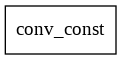

In [15]:
tf.keras.utils.plot_model(model)

In [16]:
def schedule(epoch,lr):
  if epoch%6==0:
    return lr*0.5
  else:
    return lr

In [17]:
chckpt = tf.keras.callbacks.ModelCheckpoint('model.hdf5',save_best_only=True,save_weights_only=True,monitor="val_accuracy",mode="max")
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)

In [18]:
from IPython.display import clear_output
class loss_plt(tf.keras.callbacks.Callback):
  def on_train_begin(self,logs={}):
    self.losses = []
    self.val_losses =[]
    self.accuracy = []
    self.val_accuracy =[]

  def on_epoch_end(self,epoch,logs={}):
    clear_output(wait=True)
    self.val_losses.append(logs.get('val_loss'))
    self.losses.append(logs.get('loss'))

    self.val_accuracy.append(logs.get('val_accuracy'))
    self.accuracy.append(logs.get('accuracy'))

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(self.val_losses,color="green",label="val_loss")
    plt.plot(self.losses,color="red",label="loss")
    plt.legend()
    plt.title("loss curve");

    plt.subplot(1,2,2)
    plt.plot(self.val_accuracy,color="green",label="val_accuracy")
    plt.plot(self.accuracy,color="red",label="accuracy")
    plt.legend()
    plt.title("accuracy curve");
    plt.tight_layout()
    plt.show()

loss_cback = loss_plt()

In [19]:
val_X = []
val_Y = []
l = len(os.listdir(PATH+"Test/"))

def extract_label(a):
    return float(a.split('_')[-1].split('TIF')[0][:-1])

for id,img in enumerate(tqdm(os.listdir(PATH+"Test/"))):
  im = cv2.cvtColor(cv2.imread(PATH+"Test/"+img),cv2.COLOR_BGR2GRAY).astype('float32')
  im = np.expand_dims(im,axis=2)
  lab = extract_label(img)
  label = np.zeros(10)
  label[CAND_RF.index(lab)] = 1
  val_X.append(im)
  val_Y.append(label)

val_X = np.stack(val_X)
val_Y = np.stack(val_Y)

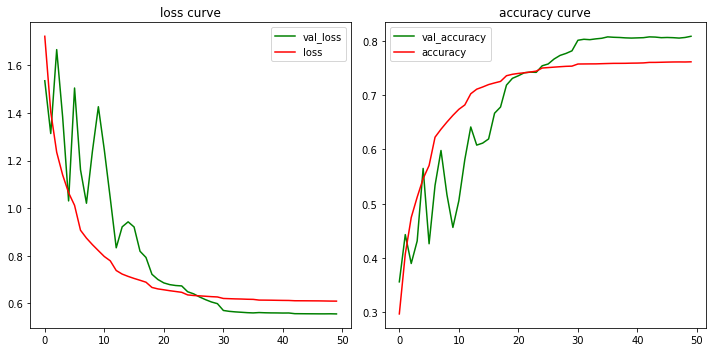

In [20]:
train_load = DataLoader(PATH+'Train/')
train = train_load.flow(batch_size=64)
weight_cback = ConstWeight(3)

history = model.fit(train,
                    steps_per_epoch = int(len(os.listdir(PATH+'Train/'))/64),
                    epochs=50,
                    validation_data=(val_X,val_Y),
                    callbacks=[chckpt,loss_cback,weight_cback,lr_scheduler],verbose=1
                    )

# Model Test with Unseen Image

(2000, 3008, 3)


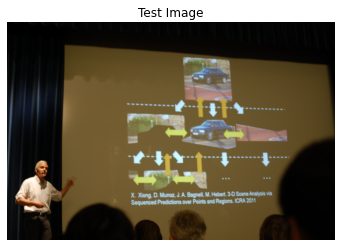

In [21]:
im = cv2.cvtColor(cv2.imread('/content/original_image.TIF'),cv2.COLOR_BGR2RGB)
plt.imshow(im);
plt.axis("off")
plt.title("Test Image");
print(im.shape)

In [23]:
def prepare_eval(image_list,crop_size=256,rfs= CAND_RF):
  images = []
  for im in image_list:
    img = cv2.cvtColor(cv2.imread('/content/'+im),cv2.COLOR_BGR2RGB)
    images.extend(extract_images(img))
  resized_images = []
  labels = []
  for im in images:
    for rf in rfs:
      label = np.zeros(10)
      label[CAND_RF.index(rf)]=1
      labels.append(label)
      r_img = cv2.resize(im,(int(im.shape[0]*rf),int(im.shape[1]*rf)),interpolation=cv2.INTER_CUBIC)
      r_img = cv2.cvtColor(r_img,cv2.COLOR_RGB2GRAY)[:256,:256]
      resized_images.append(np.expand_dims(r_img.astype('float32'),axis=2))
  return np.stack(resized_images),np.stack(labels)

X_eval,Y_eval = prepare_eval(['original_image.TIF'])

In [24]:
X_eval.shape

(150, 256, 256, 1)

In [25]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [26]:
model.load_weights('model.hdf5')
pred = model.predict(X_eval)
pred = [np.argmax(p) for p in pred]

In [27]:
y = [np.argmax(p) for p in Y_eval]

In [28]:
print(accuracy_score(y,pred))

0.9666666666666667


In [29]:
print(classification_report(y,pred))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        15
           1       1.00      0.73      0.85        15
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       0.94      1.00      0.97        15
           6       1.00      0.93      0.97        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        15

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



In [35]:
N_TEST_IMG = 30
TEST_PATH = '/content/uncompressed/test_tiff/'

def softmax(arr):
  return np.exp(arr)/np.sum(np.exp(arr))

def rf_acc(TEST_PATH,rf):
  print("For Resizing Factor {}".format(rf))
  Y_true = []
  images = []
  for img in tqdm(os.listdir(TEST_PATH)[:N_TEST_IMG]):
    image = cv2.cvtColor(cv2.imread(os.path.join(TEST_PATH,img)),cv2.COLOR_BGR2RGB)
    n_images = extract_images(image)
    n_images = [cv2.resize(i,(int(i.shape[1]*rf),int(i.shape[0]*rf)),interpolation=cv2.INTER_CUBIC) for i in n_images]
    n_images = [np.expand_dims(cv2.cvtColor(crop_img(i),cv2.COLOR_BGR2GRAY).astype("float32"),axis=2) for i in n_images]
    Y_true.extend([CAND_RF.index(rf) for _ in n_images])
    images.extend(n_images)
  print("Testing With {} images".format(len(images)))
  preds = np.stack([np.argmax(softmax(p)) for p in model.predict(np.stack(images))])
  return accuracy_score(Y_true,preds)

for rf in CAND_RF:
  print(rf_acc(TEST_PATH,rf))

For Resizing Factor 0.5



Testing With 1424 images
0.8862359550561798
For Resizing Factor 0.6



Testing With 1424 images
0.6551966292134831
For Resizing Factor 0.7



Testing With 1424 images
0.7008426966292135
For Resizing Factor 0.8



Testing With 1424 images
0.7219101123595506
For Resizing Factor 0.9



Testing With 1424 images
0.7914325842696629
For Resizing Factor 1.1



Testing With 1424 images
0.8321629213483146
For Resizing Factor 1.2



Testing With 1424 images
0.7401685393258427
For Resizing Factor 1.3



Testing With 1424 images
0.8061797752808989
For Resizing Factor 1.4



Testing With 1424 images
0.8412921348314607
For Resizing Factor 1.5



Testing With 1424 images
0.9157303370786517
